# 1. Mobile Games - Cookie Cats

***Cookie Cats*** is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. We're not kidding! Check out this short demo:



As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.



But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!

# A/B Testing Data

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

- **`userid`** - a unique number that identifies each player.
- **`version`** - whether the player was put in the control group (`gate_30` - a gate at level 30) or the group with the moved gate (`gate_40` - a gate at level 40).
- **`sum_gamerounds`** - the number of game rounds played by the player during the first 14 days after install.
- **`retention_1`** - did the player come back and play 1 day after installing?
- **`retention_7`** - did the player come back and play 7 days after installing?

Different version (gate_30 or gate_40) was assigned to players randomly when players download the app. 

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

As a sanity check, the number of version assigned to each player is collected. It seems like different version is assigned pretty fairly to the players. This is good!

In [5]:
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

# Distribution of Game Rounds

In [6]:
plot_df = df.groupby('sum_gamerounds')['userid'].count().reset_index()
plot_df.head(5)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629


I plotted the distribution graph to see the overall trend of number of players when they go higher stages in the game. 

**Insights**

1. we can see that the number of players are decreasing as the number of rounds get higher. People might spend enough time enjoying the game that majority of people get bored and stop playing the game at some point.
2. There are people really hooked after they play the game for a bit (round1 and 2).
3. It looks like there are 3994 people who never played the game after they install the app

What we want is for players to like the game and to get hooked. **A common metric** in the video gaming industry for how fun and engaging a game is **1-day retention**: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base

Text(0.5, 1.0, 'Game Rounds played during the first 14 days after install')

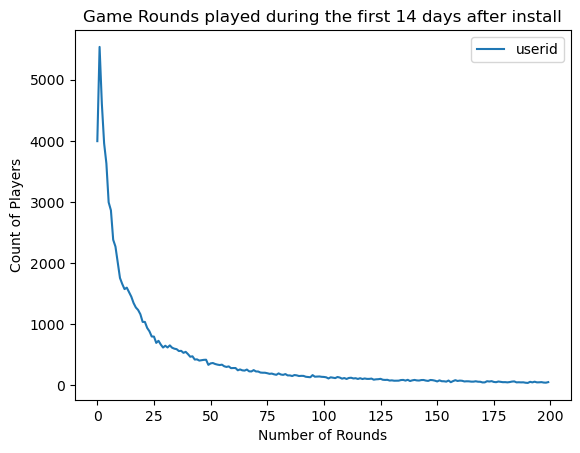

In [7]:
ax = plot_df.head(n=200).plot('sum_gamerounds', 'userid')
ax.set_xlabel('Number of Rounds')
ax.set_ylabel('Count of Players')
ax.set_title('Game Rounds played during the first 14 days after install')

# Overall 1-day Retention

This percentage refers to people who play after 1-day after installing the app.

In [10]:
df['retention_1'].mean()*100

44.52095044850259

It looks like players assigned with gate_30 version shows a slight higher 1-day retention rate (44.8%) compared to gate_40 (44.2%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

# 1-Day Retention by A/B Group

In [12]:
df.groupby('version')['retention_1'].mean()*100

version
gate_30    44.818792
gate_40    44.228275
Name: retention_1, dtype: float64

# Should we be confident in the difference?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use **bootstrapping**: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

Text(0.5, 0, 'Average 1-day retention')

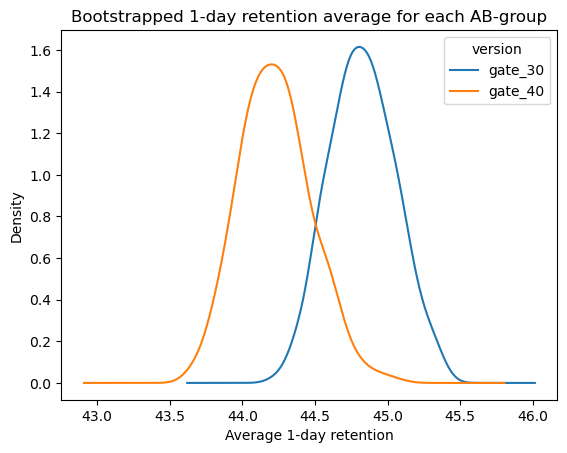

In [25]:
boot_1d = []
iterations = 500

for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()*100
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)

ax = boot_1d.plot.kde()
ax.set_title('Bootstrapped 1-day retention average for each AB-group')
ax.set_xlabel('Average 1-day retention')

The above graph shows that there are obviously difference in 1-day retention rate by small gap.

# Zooming in on the Difference

Text(0.5, 1.0, 'Bootstrap percent difference in 1-day retention average')

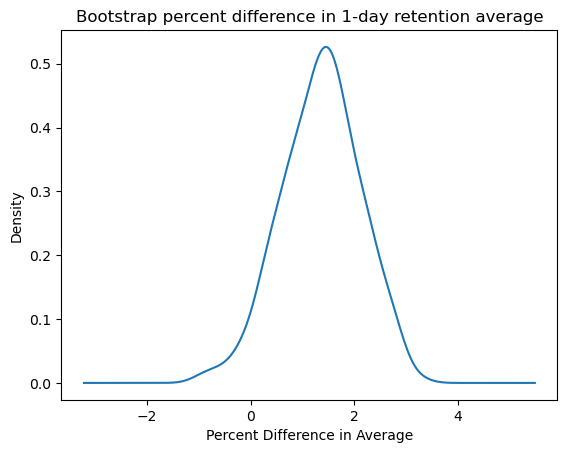

In [27]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40'])/
                  boot_1d['gate_40']*100)
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Percent Difference in Average')
ax.set_title('Bootstrap percent difference in 1-day retention average')

As we expected above, the average percent difference is 1%-2%. But, what is the probability that the difference is above 0%? 

In [30]:
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])
'{0:.1%}'.format(prob)

'96.2%'

It tells that 1-day retention rate was higher in players who were assigned with version (gate_30) with 96.2%. It is obvious that setting the forced stop moment at gate 30 is efficient to make player's retention rate higher.

**However**, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

# 7-day retention by A/B Group

In [32]:
df.groupby('version')['retention_7'].mean()*100

version
gate_30    19.020134
gate_40    18.200004
Name: retention_7, dtype: float64

Here, we can see that the overall 7-days retention rate for players decreased from about 44% to 18% compared to 1-day retention rate. It shows that a lot of people stopped playing game within a week. Also, it is similar that players assigned with gate_30 shows higher 7-days retention rate. We can get a hint that still making players stop playing games at gate 30 is effective way to engage players and drive in-app purchases. 

# Bootstrapping the difference in 7-day Retention

Text(0.5, 1.0, 'Bootstrap percentage Difference in 7-Day Retention Average')

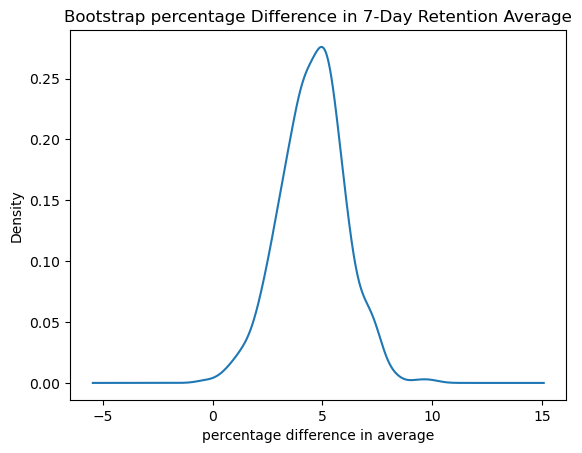

In [35]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / 
                   boot_7d['gate_40'] * 100)

ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("percentage difference in average")
ax.set_title('Bootstrap percentage Difference in 7-Day Retention Average')

In [34]:
prob = (boot_7d['diff'] > 0).mean()
'{0:.1%}'.format(prob)

'100.0%'

# Conclusion

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. **The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40**. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game

In [36]:
move_to_level_40 = False